# Policy Optimisation for Basic Bathtub Scenario

Find optimal parameters for the linear interval policy using the **(c, r) parameterisation**:

```
interval = c * (1 + r * (durability - 1))
```

Where:
- **c** = service interval at mean durability (higher = less frequent service)
- **r** = durability sensitivity ratio:
  - r = 0: ignore durability (fixed interval = c)
  - r = 1: fully proportional (interval = c × durability)
  - r < 0: more service for durable subjects (counterintuitive)
  - r > 1: interval scales faster than durability

This is equivalent to `interval = a + b * durability` with `a = c(1-r)` and `b = cr`.

**Note:** This linear policy is limited. RL could find dynamic policies that drift through the infant mortality zone then stay in the minimum hazard region.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from src.scenarios import BasicBathtubScenario
from src.policy import LinearIntervalPolicy, NoOpPolicy, FixedIntervalPolicy
from src.runner import run_scenario, compare_policies
from src.optimisation import optimise_policy, grid_search, sensitivity_analysis

## Setup

In [2]:
# Scenario with cheap service (profitable to service)
scenario = BasicBathtubScenario(
    scale1=100.0,
    scale2=200.0,
    service_cost=0.5,
    failure_cost=150.0,
    revenue_per_time=1.50,
)

# Print key parameters for reference
print("Scenario parameters:")
print(f"  Bathtub shape: shape1={scenario.failure_model.shape1}, shape2={scenario.failure_model.shape2}")
print(f"  Scales: scale1={scenario.failure_model.scale1}, scale2={scenario.failure_model.scale2}")
print(f"  Delta_t (age reduction per service): {scenario.failure_model.delta_t}")
print(f"  Costs: service={scenario.costs.service_cost}, failure={scenario.costs.failure_cost}")
print(f"  Revenue per time: {scenario.costs.revenue_per_time}")

MAX_TIME = 150.0
N_SAMPLES = 2000

Scenario parameters:
  Bathtub shape: shape1=0.5, shape2=3.0
  Scales: scale1=100.0, scale2=200.0
  Delta_t (age reduction per service): 15.0
  Costs: service=0.5, failure=150.0
  Revenue per time: 1.5


## Policy Factory

Convert (c, r) to LinearIntervalPolicy(a, b).

In [3]:
def policy_factory_cr(params):
    """Create policy from (c, r) parameters."""
    c, r = params
    a = c * (1 - r)
    b = c * r
    return LinearIntervalPolicy(a=a, b=b)

def cr_to_ab(c, r):
    """Convert (c, r) to (a, b)."""
    return c * (1 - r), c * r

def ab_to_cr(a, b):
    """Convert (a, b) to (c, r)."""
    c = a + b
    r = b / c if c > 0 else 0
    return c, r

## Sanity Check: No-Op vs Baseline

In [4]:
no_op = NoOpPolicy()
baseline_cr = (25.0, 0.4)  # c=25, r=0.4 -> a=15, b=10
baseline = policy_factory_cr(baseline_cr)

result_no_op = run_scenario(scenario, no_op, N_SAMPLES, MAX_TIME, seed=42)
result_baseline = run_scenario(scenario, baseline, N_SAMPLES, MAX_TIME, seed=42)

print(f"No-Op:    {result_no_op.mean_net_value:.1f}")
print(f"Baseline: {result_baseline.mean_net_value:.1f} (c={baseline_cr[0]}, r={baseline_cr[1]})")
print(f"Delta:    {result_baseline.mean_net_value - result_no_op.mean_net_value:+.1f}")

No-Op:    -31.1
Baseline: -34.2 (c=25.0, r=0.4)
Delta:    -3.1


## Grid Search in (c, r) Space

In [5]:
c_values = np.linspace(10, 150, 30)  # 2x denser
r_values = np.linspace(-1.0, 2.5, 46)  # 2x denser, wider range

print(f"Grid search: {len(c_values)} x {len(r_values)} = {len(c_values)*len(r_values)} combinations")
best_cr, best_value, grid_results = grid_search(
    scenario, policy_factory_cr, [c_values, r_values],
    n_subjects=N_SAMPLES, max_time=MAX_TIME, seed=42, verbose=True
)
a, b = cr_to_ab(*best_cr)
print(f"\nBest: c={best_cr[0]:.1f}, r={best_cr[1]:.2f} (a={a:.1f}, b={b:.1f}) -> {best_value:.1f}")

Grid search: 30 x 46 = 1380 combinations
Grid search: 1380 combinations
  25/1380: best=-103.25 at [10.          0.86666667]
  50/1380: best=-81.73 at [14.82758621 -1.        ]
  75/1380: best=-75.17 at [14.82758621  1.17777778]
  100/1380: best=-50.44 at [19.65517241 -0.61111111]
  125/1380: best=-39.58 at [19.65517241  0.16666667]
  150/1380: best=-31.99 at [24.48275862 -0.14444444]
  175/1380: best=-31.99 at [24.48275862 -0.14444444]
  200/1380: best=-28.41 at [29.31034483  0.16666667]
  225/1380: best=-26.77 at [29.31034483  0.71111111]
  250/1380: best=-23.81 at [34.13793103 -0.3       ]
  275/1380: best=-23.71 at [34.13793103  0.63333333]
  300/1380: best=-19.79 at [38.96551724  0.63333333]
  325/1380: best=-19.79 at [38.96551724  0.63333333]
  350/1380: best=-19.79 at [38.96551724  0.63333333]
  375/1380: best=-19.79 at [38.96551724  0.63333333]
  400/1380: best=-18.43 at [48.62068966  1.25555556]
  425/1380: best=-18.43 at [48.62068966  1.25555556]
  450/1380: best=-18.43 at [4

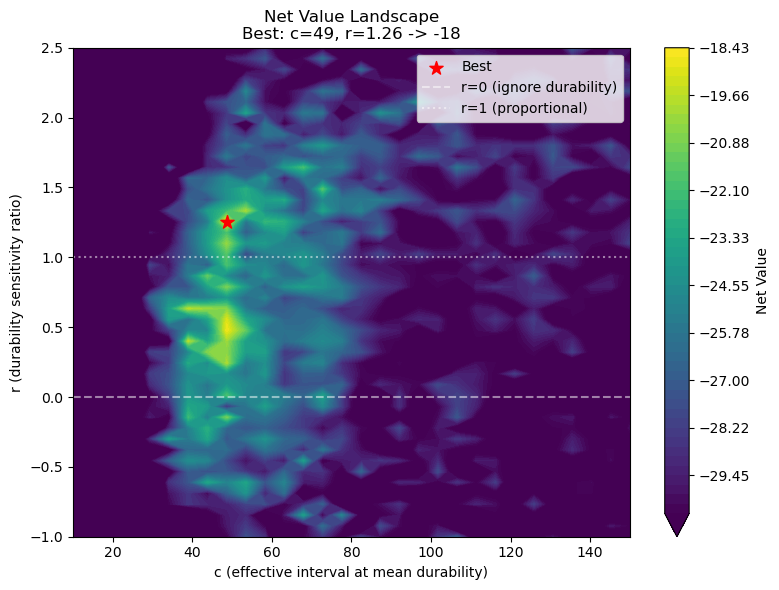

Interpretation:
- Higher c = less frequent service
- r < 0: shorter intervals for durable subjects
- r > 1: interval grows faster than durability
- Color range: [-30, -18] with 50 levels


In [6]:
# Visualise landscape with color sensitivity near optimum
fig, ax = plt.subplots(figsize=(8, 6))

# Focus color range on top 50% of values with many levels for detail
vmin = np.percentile(grid_results, 50)
vmax = grid_results.max()
levels = np.linspace(vmin, vmax, 50)  # Many levels for fine gradation

im = ax.contourf(c_values, r_values, grid_results.T, levels=levels, cmap='viridis', extend='min')
ax.scatter([best_cr[0]], [best_cr[1]], color='red', s=100, marker='*', label='Best', zorder=5)
ax.axhline(0, color='white', linestyle='--', alpha=0.5, label='r=0 (ignore durability)')
ax.axhline(1, color='white', linestyle=':', alpha=0.5, label='r=1 (proportional)')
ax.set_xlabel('c (effective interval at mean durability)')
ax.set_ylabel('r (durability sensitivity ratio)')
ax.set_title(f'Net Value Landscape\nBest: c={best_cr[0]:.0f}, r={best_cr[1]:.2f} -> {best_value:.0f}')
ax.legend(loc='upper right')
plt.colorbar(im, ax=ax, label='Net Value')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Higher c = less frequent service")
print("- r < 0: shorter intervals for durable subjects")
print("- r > 1: interval grows faster than durability")
print(f"- Color range: [{vmin:.0f}, {vmax:.0f}] with 50 levels")

## Nelder-Mead Optimisation

Simplex-based method, often better behaved for noisy objectives.

In [7]:
# Nelder-Mead optimisation starting from grid search best
opt_result = optimise_policy(
    scenario,
    policy_factory_cr,
    initial_params=best_cr,
    bounds=[(5.0, 200.0), (-1.0, 2.5)],  # Note: Nelder-Mead ignores bounds
    n_subjects=N_SAMPLES,
    max_time=MAX_TIME,
    method='Nelder-Mead',
    seed=42,
    verbose=True
)

Optimising with method=Nelder-Mead
  Initial: [48.62068966  1.25555556]
  Bounds:  [(5.0, 200.0), (-1.0, 2.5)]

  Eval   5: params=[47.41  1.3 ], value=-24.10
  Eval  10: params=[48.16  1.27], value=-19.52
  Eval  15: params=[48.43  1.26], value=-19.38
  Eval  20: params=[48.68  1.26], value=-18.28
  Eval  25: params=[48.63  1.26], value=-18.44
  Eval  30: params=[48.68  1.26], value=-18.27
  Eval  35: params=[48.66  1.26], value=-18.27
  Eval  40: params=[48.69  1.26], value=-18.29
  Eval  45: params=[48.68  1.26], value=-23.65
  Eval  50: params=[48.68  1.26], value=-23.66
  Eval  55: params=[48.68  1.26], value=-23.66
  Eval  60: params=[48.68  1.26], value=-18.15
  Eval  65: params=[48.69  1.26], value=-18.15
  Eval  70: params=[48.69  1.26], value=-18.15
  Eval  75: params=[48.69  1.26], value=-18.28
  Eval  80: params=[48.69  1.26], value=-18.15
  Eval  85: params=[48.69  1.26], value=-23.66
  Eval  90: params=[48.69  1.26], value=-18.15

Done in 8.2s (94 evaluations)
  Initial: 

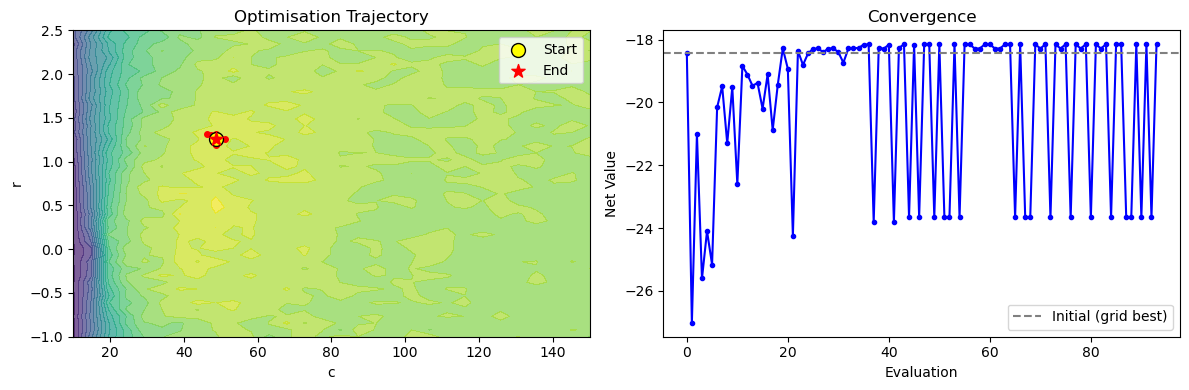

Grid search: c=48.6, r=1.26 -> -18.4
Powell:      c=48.7, r=1.26 -> -18.1


In [8]:
# Plot optimisation trajectory
history = np.array([h[0] for h in opt_result.history])
values = np.array([h[1] for h in opt_result.history])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Trajectory on contour
axes[0].contourf(c_values, r_values, grid_results.T, levels=20, cmap='viridis', alpha=0.7)
axes[0].plot(history[:, 0], history[:, 1], 'r.-', markersize=8, linewidth=1)
axes[0].scatter([history[0, 0]], [history[0, 1]], color='yellow', s=100, edgecolors='black', zorder=5, label='Start')
axes[0].scatter([history[-1, 0]], [history[-1, 1]], color='red', s=100, marker='*', zorder=5, label='End')
axes[0].set_xlabel('c')
axes[0].set_ylabel('r')
axes[0].set_title('Optimisation Trajectory')
axes[0].legend()

# Value over iterations
axes[1].plot(values, 'b.-')
axes[1].axhline(opt_result.initial_value, color='gray', linestyle='--', label='Initial (grid best)')
axes[1].set_xlabel('Evaluation')
axes[1].set_ylabel('Net Value')
axes[1].set_title('Convergence')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Grid search: c={best_cr[0]:.1f}, r={best_cr[1]:.2f} -> {best_value:.1f}")
print(f"Powell:      c={opt_result.optimal_params[0]:.1f}, r={opt_result.optimal_params[1]:.2f} -> {opt_result.optimal_value:.1f}")

## Multi-Start Optimisation

Find multiple peaks in the landscape and optimise from each.

In [9]:
# Find top grid points, cluster adjacent ones, optimize from each cluster centroid
from scipy.ndimage import label, center_of_mass

# Find top N% of grid points
threshold = np.percentile(grid_results, 95)  # Top 5%
peaks_mask = grid_results >= threshold

# Label connected regions (islands)
labeled, n_islands = label(peaks_mask)
print(f"Found {n_islands} islands in top 5% of grid")

# Get centroid of each island and its best value
island_starts = []
for i in range(1, n_islands + 1):
    # Find all points in this island
    island_points = np.argwhere(labeled == i)
    island_values = [grid_results[tuple(p)] for p in island_points]
    
    # Use best point in island as starting point (more reliable than centroid)
    best_idx = np.argmax(island_values)
    best_point = island_points[best_idx]
    c_start = c_values[best_point[0]]
    r_start = r_values[best_point[1]]
    value = island_values[best_idx]
    
    island_starts.append((c_start, r_start, value, len(island_points)))

# Sort by value (best first)
island_starts.sort(key=lambda x: -x[2])

print(f"\nIsland starting points (sorted by value):")
print(f"{'Island':<8} {'c':>8} {'r':>8} {'Value':>10} {'Size':>6}")
print("-" * 45)
for i, (c, r, v, size) in enumerate(island_starts):
    print(f"{i+1:<8} {c:>8.1f} {r:>8.2f} {v:>10.1f} {size:>6}")

Found 27 islands in top 5% of grid

Island starting points (sorted by value):
Island          c        r      Value   Size
---------------------------------------------
1            48.6     1.26      -18.4     14
2            48.6     0.48      -18.7     23
3            48.6    -0.14      -21.0      1
4            72.8     1.49      -21.7      1
5            48.6     0.01      -22.0      2
6            67.9     1.64      -22.1      2
7            39.0    -0.14      -22.3      3
8            58.3     1.26      -22.5      3
9            43.8    -0.22      -22.8      2
10           39.0     0.24      -23.2      1
11           43.8    -0.61      -23.3      1
12           53.4    -0.61      -23.5      1
13           72.8     1.33      -23.5      1
14           53.4     2.03      -23.6      1
15           67.9     0.79      -23.7      1
16           72.8     0.01      -23.7      1
17           58.3    -0.07      -23.7      1
18           67.9    -0.46      -23.7      1
19           67.9    

In [10]:
# Optimize from top 5 islands (or all if fewer)
n_to_optimize = min(5, len(island_starts))
optimized_results = []

print(f"Optimizing from top {n_to_optimize} islands...\n")
for i, (c_start, r_start, grid_val, _) in enumerate(island_starts[:n_to_optimize]):
    print(f"Island {i+1}: starting at c={c_start:.1f}, r={r_start:.2f} (grid value={grid_val:.1f})")
    
    result = optimise_policy(
        scenario,
        policy_factory_cr,
        initial_params=np.array([c_start, r_start]),
        bounds=[(5.0, 200.0), (-1.0, 2.5)],
        n_subjects=N_SAMPLES,
        max_time=MAX_TIME,
        method='Nelder-Mead',
        seed=42,
        verbose=False
    )
    
    optimized_results.append({
        'island': i + 1,
        'start': (c_start, r_start),
        'start_value': grid_val,
        'optimal': result.optimal_params,
        'optimal_value': result.optimal_value,
        'converged': result.converged
    })
    
    print(f"  -> c={result.optimal_params[0]:.1f}, r={result.optimal_params[1]:.2f}, value={result.optimal_value:.1f}")
    print()

# Summary table
print("\n" + "=" * 70)
print("MULTI-START SUMMARY")
print("=" * 70)
print(f"{'Island':<8} {'Start c':>8} {'Start r':>8} {'Opt c':>8} {'Opt r':>8} {'Value':>10}")
print("-" * 70)
for res in optimized_results:
    print(f"{res['island']:<8} {res['start'][0]:>8.1f} {res['start'][1]:>8.2f} "
          f"{res['optimal'][0]:>8.1f} {res['optimal'][1]:>8.2f} {res['optimal_value']:>10.1f}")

best_result = max(optimized_results, key=lambda x: x['optimal_value'])
print(f"\nBest overall: Island {best_result['island']} -> c={best_result['optimal'][0]:.1f}, r={best_result['optimal'][1]:.2f}, value={best_result['optimal_value']:.1f}")

Optimizing from top 5 islands...

Island 1: starting at c=48.6, r=1.26 (grid value=-18.4)
  -> c=48.7, r=1.26, value=-18.1

Island 2: starting at c=48.6, r=0.48 (grid value=-18.7)
  -> c=48.4, r=0.50, value=-17.9

Island 3: starting at c=48.6, r=-0.14 (grid value=-21.0)
  -> c=48.6, r=-0.14, value=-19.6

Island 4: starting at c=72.8, r=1.49 (grid value=-21.7)
  -> c=73.3, r=1.49, value=-19.3

Island 5: starting at c=48.6, r=0.01 (grid value=-22.0)
  -> c=48.2, r=0.01, value=-20.8


MULTI-START SUMMARY
Island    Start c  Start r    Opt c    Opt r      Value
----------------------------------------------------------------------
1            48.6     1.26     48.7     1.26      -18.1
2            48.6     0.48     48.4     0.50      -17.9
3            48.6    -0.14     48.6    -0.14      -19.6
4            72.8     1.49     73.3     1.49      -19.3
5            48.6     0.01     48.2     0.01      -20.8

Best overall: Island 2 -> c=48.4, r=0.50, value=-17.9


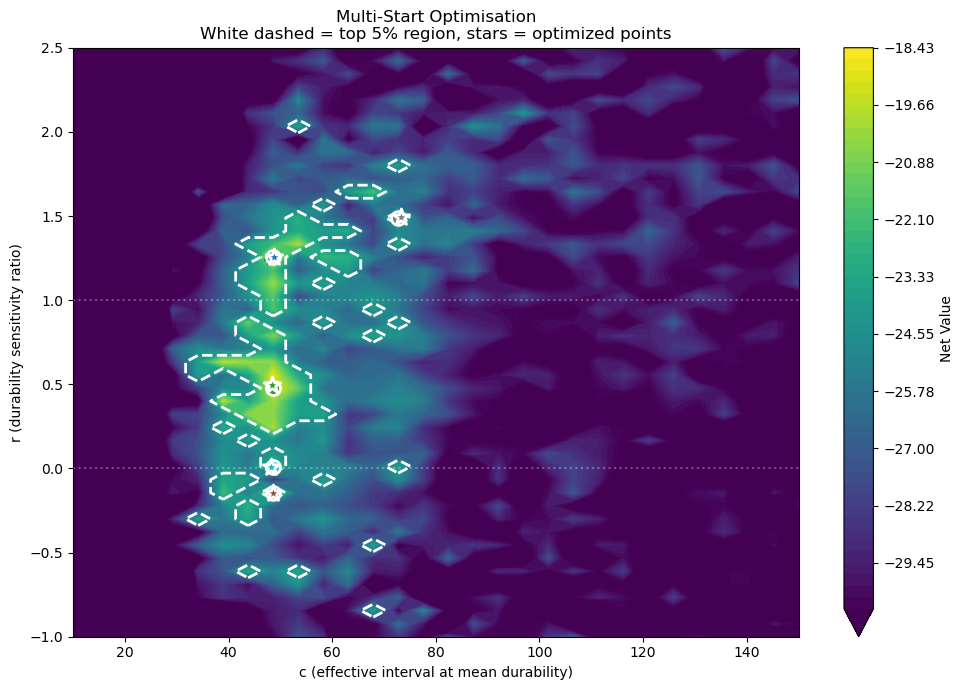

In [11]:
# Visualise islands and optimized points
fig, ax = plt.subplots(figsize=(10, 7))

# Background contour
im = ax.contourf(c_values, r_values, grid_results.T, levels=levels, cmap='viridis', extend='min')

# Mark islands (top 5% region)
ax.contour(c_values, r_values, peaks_mask.T, levels=[0.5], colors='white', linewidths=2, linestyles='--')

# Plot start and end points for each optimized island
colors = plt.cm.tab10(np.linspace(0, 1, n_to_optimize))
for i, res in enumerate(optimized_results):
    ax.scatter([res['start'][0]], [res['start'][1]], color=colors[i], s=100, 
               marker='o', edgecolors='white', linewidths=2, label=f"Island {res['island']} start", zorder=5)
    ax.scatter([res['optimal'][0]], [res['optimal'][1]], color=colors[i], s=150, 
               marker='*', edgecolors='white', linewidths=2, zorder=6)
    # Arrow from start to end
    ax.annotate('', xy=res['optimal'], xytext=res['start'],
                arrowprops=dict(arrowstyle='->', color=colors[i], lw=2))

ax.axhline(0, color='white', linestyle=':', alpha=0.3)
ax.axhline(1, color='white', linestyle=':', alpha=0.3)
ax.set_xlabel('c (effective interval at mean durability)')
ax.set_ylabel('r (durability sensitivity ratio)')
ax.set_title(f'Multi-Start Optimisation\nWhite dashed = top 5% region, stars = optimized points')
plt.colorbar(im, ax=ax, label='Net Value')

plt.tight_layout()
plt.show()

## Policy Comparison

In [12]:
# Compare policies (uses multiple seeds for robust comparison)
policies = {
    'No Service': NoOpPolicy(),
    'Fixed (c=25)': FixedIntervalPolicy(interval=25.0),
    'Baseline (c=25, r=0.4)': policy_factory_cr((25.0, 0.4)),
    'Grid Best': policy_factory_cr(best_cr),
    'Powell': policy_factory_cr(opt_result.optimal_params),
}

comparison = compare_policies(
    scenario, policies,
    n_subjects=N_SAMPLES,
    max_time=MAX_TIME,
    n_repeats=5,
    seed=42
)

print(f"{'Policy':<25} {'Mean':>10} {'Std':>8} {'Params':<25}")
print("-" * 70)
for name, result in comparison.items():
    params_str = ''
    if name == 'Grid Best':
        params_str = f'c={best_cr[0]:.1f}, r={best_cr[1]:.2f}'
    elif name == 'Powell':
        params_str = f'c={opt_result.optimal_params[0]:.1f}, r={opt_result.optimal_params[1]:.2f}'
    print(f"{name:<25} {result['mean']:>10.1f} {result['std']:>8.1f} {params_str:<25}")

print(f"\nGrid search value (seed=42): {best_value:.1f}")
print("Note: Comparison averages over 5 different seeds for robustness.")

Policy                          Mean      Std Params                   
----------------------------------------------------------------------
No Service                     -28.1      2.6                          
Fixed (c=25)                   -32.7      1.7                          
Baseline (c=25, r=0.4)         -32.7      2.4                          
Grid Best                      -24.2      3.5 c=48.6, r=1.26           
Powell                         -23.9      4.3 c=48.7, r=1.26           

Grid search value (seed=42): -18.4
Note: Comparison averages over 5 different seeds for robustness.


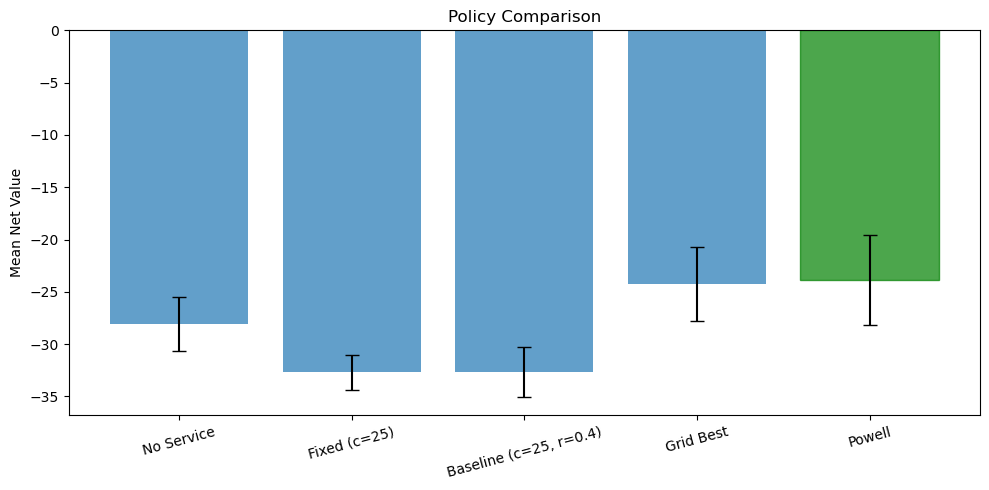

In [13]:
# Bar chart
names = list(comparison.keys())
means = [comparison[n]['mean'] for n in names]
stds = [comparison[n]['std'] for n in names]

plt.figure(figsize=(10, 5))
bars = plt.bar(names, means, yerr=stds, capsize=5, alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Mean Net Value')
plt.title('Policy Comparison')
plt.xticks(rotation=15)

best_idx = np.argmax(means)
bars[best_idx].set_color('green')

plt.tight_layout()
plt.show()

## Sensitivity Analysis

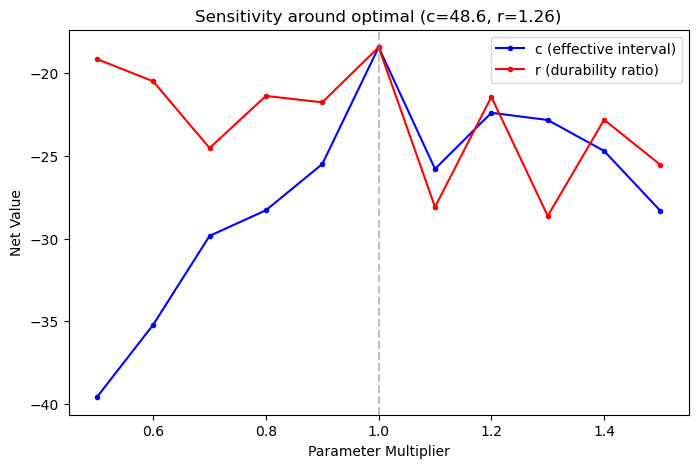

Interpretation:
- Steeper curve = more sensitive parameter
- c (interval) typically has larger effect than r (personalisation)


In [14]:
sens = sensitivity_analysis(
    scenario,
    policy_factory_cr,
    base_params=np.array(best_cr),
    param_names=['c', 'r'],
    variations=np.linspace(0.5, 1.5, 11),
    n_subjects=N_SAMPLES,
    max_time=MAX_TIME,
    seed=42
)

plt.figure(figsize=(8, 5))
plt.plot(sens['multipliers'], sens['c'], 'b.-', label='c (effective interval)')
plt.plot(sens['multipliers'], sens['r'], 'r.-', label='r (durability ratio)')
plt.axvline(1.0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Parameter Multiplier')
plt.ylabel('Net Value')
plt.title(f'Sensitivity around optimal (c={best_cr[0]:.1f}, r={best_cr[1]:.2f})')
plt.legend()
plt.show()

print("Interpretation:")
print("- Steeper curve = more sensitive parameter")
print("- c (interval) typically has larger effect than r (personalisation)")

## Summary

In [15]:
print("=" * 60)
print("OPTIMISATION SUMMARY")
print("=" * 60)

print(f"\nScenario:")
print(f"  Bathtub: shape1={scenario.failure_model.shape1}, shape2={scenario.failure_model.shape2}")
print(f"  Costs:   service={scenario.costs.service_cost}, failure={scenario.costs.failure_cost}")
print(f"  Revenue: {scenario.costs.revenue_per_time}/time")

print(f"\nBest policy found:")
print(f"  Grid search: c={best_cr[0]:.1f}, r={best_cr[1]:.2f} -> {best_value:.1f}")

print("\nParameterisation: interval = c * (1 + r * (durability - 1))")
print("  c: service interval at mean durability")
print("  r: durability sensitivity (can be <0 or >1)")

print("\nLimitations of linear policy:")
print("  - Fixed interval regardless of current effective age")
print("  - Cannot adapt dynamically to state")
print("  - RL could find policies that:")
print("    1. Drift through infant mortality (low service early)")
print("    2. Stay in minimum hazard region (frequent service once there)")

OPTIMISATION SUMMARY

Scenario:
  Bathtub: shape1=0.5, shape2=3.0
  Costs:   service=0.5, failure=150.0
  Revenue: 1.5/time

Best policy found:
  Grid search: c=48.6, r=1.26 -> -18.4

Parameterisation: interval = c * (1 + r * (durability - 1))
  c: service interval at mean durability
  r: durability sensitivity (can be <0 or >1)

Limitations of linear policy:
  - Fixed interval regardless of current effective age
  - Cannot adapt dynamically to state
  - RL could find policies that:
    1. Drift through infant mortality (low service early)
    2. Stay in minimum hazard region (frequent service once there)
